In [24]:
from PIL import Image, ImageDraw
import PIL
import time
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import os
from pathlib import Path
from shapely import wkt

import logging
import json

from collections import defaultdict
from mask_extraction import parse_json
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
logging.basicConfig(level=logging.INFO)

# Configurations
NUM_WORKERS = 4
NUM_CLASSES = 4
BATCH_SIZE = 64
NUM_EPOCHS = 120
LEARNING_RATE = 0.0001
RANDOM_SEED = 123
LOG_STEP = 150

damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['no-damage'] = 0

def parse_json(label_json):
    df_xy = pd.DataFrame([{'id': x['properties']['uid'], 'feature': x['properties']['feature_type'],
                           'damage': x['properties'].get('subtype', 'no-damage'),
                           'geometry_pixel': x['wkt']} for x in label_json['features']['xy']])
    df_lnglat = pd.DataFrame(
        [{'id': x['properties']['uid'], 'geometry_lnglat': x['wkt'], } for x in label_json['features']['lng_lat']])
    if len(df_xy) == 0:
        return
    df_xy.set_index('id', inplace=True)

    df_xy['damage_cls'] = df_xy['damage'].map({
        'no-damage': 1, 'minor-damage': 2, 'major-damage': 3, 'destroyed': 4, 'un-classified': 5
    })
    df_xy.geometry_pixel = df_xy.geometry_pixel.apply(wkt.loads)
    df_lnglat.set_index('id', inplace=True)
    label_df = df_xy.merge(df_lnglat['geometry_lnglat'], left_index=True, right_index=True)
#     print(label_df.head())
#     label_gdf = gpd.GeoDataFrame(label_df, geometry='geometry_pixel')
#     print('here')
    label_df['centroid'] = label_gdf.geometry_pixel.centroid
#     print('here2')
    return label_df


def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    # Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    img_patch=img_array[ymin:ymax, xmin:xmax, :]

    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon_pts, outline=1, fill=1)
    mask = np.array(mask)
    print(mask.max())

    return (img_array * mask[..., None])[ymin:ymax, xmin:xmax, :]


def process_data(data_dir, image_crops_dir, output_csv_path,):
    """Process Raw Data into
        Args:
            dir_path (path): Path to the xBD dataset.
            data_type (string): String to indicate whether to process
                                train, test, or holdout data.
        Returns:
            x_data: A list of numpy arrays representing the images for training
            y_data: A list of labels for damage represented in matrix form
    """
    data = []

    images = [Path(x) for x in os.listdir(data_dir / "train" / "images") if 'post_disaster' in x]
    labels = [data_dir / "train" / "labels"/(x.name.replace('png', 'json')) for x in images]
    print(len(images), len(labels))
    for label_file, img_file in tqdm(zip(labels, images)):
        with open(label_file, 'r') as f:
            label = json.load(f)
        label_gdf = parse_json(label)
        if label_gdf is None or len(label_gdf) == 0:
            continue
        img_array = np.array(Image.open(data_dir / "train" / "images"/img_file))
        for r in label_gdf.iterrows():
            row = r[1]
            poly_uuid = r[0]
            damage_type = damage_intensity_encoding[row['damage']]
            polygon_pts = np.array(list(row.geometry_pixel.exterior.coords))
            poly_img = PIL.Image.fromarray(process_img(img_array, polygon_pts, 0.8))
            poly_img.save(image_crops_dir / f"{poly_uuid}.png")

            data.append({'uuid': poly_uuid, 'img_id': img_file.name, 'label': damage_type})

    output_train_csv_path = output_csv_path/ "train_black_white.csv"

    df = pd.DataFrame(data)
#     df.to_csv(output_train_csv_path)

    return df

In [5]:

data_dir = Path("/media/wwymak/Storage/xView2")
image_crops_dir = data_dir / "classification_crops_black_white"
images = [Path(x) for x in os.listdir(data_dir / "train" / "images") if 'post_disaster' in x]
labels = [data_dir / "train" / "labels"/(x.name.replace('png', 'json')) for x in images]
print(len(images), len(labels))



2799 2799


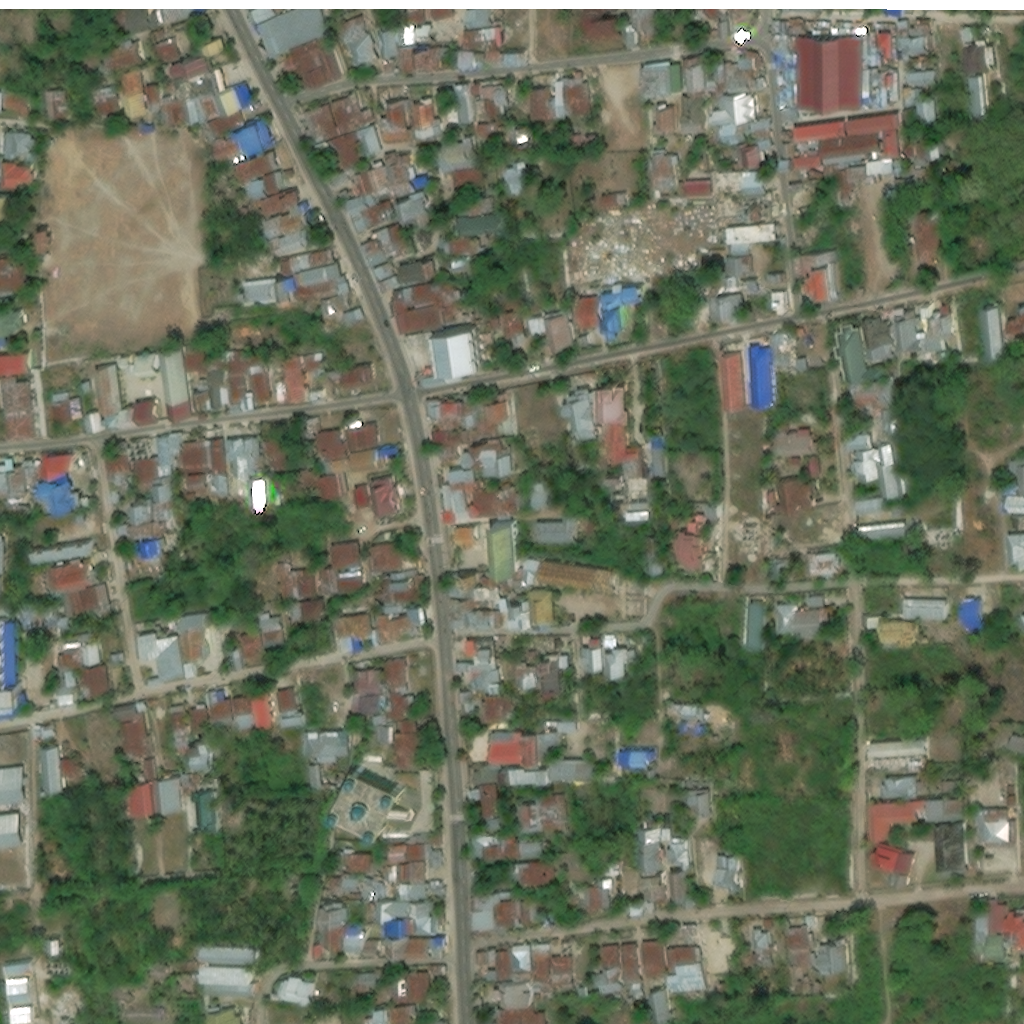

In [7]:
PIL.Image.open(data_dir / "train" / "images"/images[0])

In [12]:
label_file = data_dir / "train" / "labels"/ labels[0]
img_file = data_dir / "train" / "images"/images[0]
with open(label_file, 'r') as f:
    label = json.load(f)
    label_gdf = parse_json(label)

img_array = np.array(Image.open(data_dir / "train" / "images"/img_file))
# for r in label_gdf.iterrows():
#     row = r[1]
#     poly_uuid = r[0]
#     damage_type = damage_intensity_encoding[row['damage']]
#     polygon_pts = np.array(list(row.geometry_pixel.exterior.coords))
#     poly_img = PIL.Image.fromarray(process_img(img_array, polygon_pts, 0.8))
#     poly_img.save(image_crops_dir / f"{poly_uuid}.png")

#     data.append({'uuid': poly_uuid, 'img_id': img_file.name, 'label': damage_type})

In [13]:
label_gdf.head()

,feature,damage,geometry_pixel,damage_cls,geometry_lnglat,centroid
id,,,,,,
93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,building,no-damage,"POLYGON ((1005.249981247345 934.6299999080635,...",1,POLYGON ((119.8772266625271 -0.795167260292315...,POINT (996.598 948.375)
437988fc-fb7e-4b0e-8ccf-403015a737b3,building,no-damage,"POLYGON ((1013.567965237393 937.9587128087335,...",1,POLYGON ((119.8772638786411 -0.795182222137726...,POINT (1011.478 941.011)
63d78637-7c40-40c7-a1b3-55152a64415a,building,no-damage,"POLYGON ((1023.999981241444 912.9526688296791,...",1,POLYGON ((119.8773104622632 -0.795069596365883...,POINT (1015.693 927.991)
31ccdff0-b7f7-4884-8e55-d35e4d2c1770,building,no-damage,"POLYGON ((997.9098362148175 902.2102272435095,...",1,POLYGON ((119.8771937294637 -0.795021309031589...,POINT (996.862 918.178)
67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,building,no-damage,"POLYGON ((900.864873393806 873.7983410712188, ...",1,POLYGON ((119.8767595658149 -0.794893685405280...,POINT (901.108 881.155)


In [20]:
row = label_gdf.iloc[0]
np.array(row.geometry_pixel.exterior.coords)

array([[1005.249981,  934.63    ],
       [1005.158329,  934.699269],
       [1007.842429,  938.494031],
       [1009.029981,  960.18    ],
       [ 985.702199,  961.113426],
       [ 983.162033,  945.286236],
       [ 988.149981,  936.06    ],
       [ 997.119442,  936.336706],
       [ 996.931179,  934.454081],
       [1005.249981,  934.63    ]])

In [26]:
row = label_gdf.iloc[2]
scale_pct=0.1
polygon_pts =np.array(list(row.geometry_pixel.exterior.coords), np.int32) 
height, width, _ = img_array.shape

xcoords = polygon_pts[:, 0]
ycoords = polygon_pts[:, 1]
xmin, xmax = np.min(xcoords), np.max(xcoords)
ymin, ymax = np.min(ycoords), np.max(ycoords)

xdiff = xmax - xmin
ydiff = ymax - ymin

# Extend image by scale percentage
xmin = max(int(xmin - (xdiff * scale_pct)), 0)
xmax = min(int(xmax + (xdiff * scale_pct)), width)
ymin = max(int(ymin - (ydiff * scale_pct)), 0)
ymax = min(int(ymax + (ydiff * scale_pct)), height)

img_patch=img_array[ymin:ymax, xmin:xmax, :]

# mask = Image.new('L', (width, height), 0)
# ImageDraw.Draw(mask).polygon(polygon_pts, outline=1, fill=1)
# mask = np.array(mask)

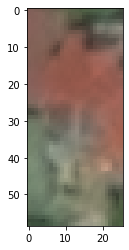

In [27]:
plt.imshow(img_patch)

In [28]:
mask = Image.new('L', (width, height), 0)
ImageDraw.Draw(mask).polygon(polygon_pts, outline=1, fill=1)
mask = np.array(mask)

In [38]:
PIL.Image.fromarray(mask[ymin:ymax, xmin:xmax] * 255)

In [40]:
from cv2 import fillPoly

In [48]:
mask_img = np.zeros((1024, 1024, 1), np.uint8)
fillPoly(mask_img, np.array([polygon_pts]), 1)
mask_img.max()

1

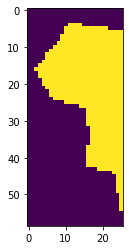

In [51]:
polygon_pts =np.array(list(row.geometry_pixel.exterior.coords), np.int32) 
fillPoly(mask_img, np.array([polygon_pts]), 1)
mask_img.max()
plt.imshow(mask_img[ymin:ymax, xmin:xmax, :].squeeze())

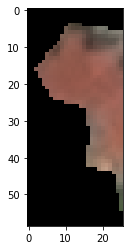

In [52]:
plt.imshow(img_patch * mask_img[ymin:ymax, xmin:xmax, :])

In [53]:
labels[0]

PosixPath('/media/wwymak/Storage/xView2/train/labels/palu-tsunami_00000024_post_disaster.json')